In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import src.infovae as infovae
import src.mri as mri

import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
nn = infovae.InfoVAE(6, 8, 4)
f = mri.MRI(N=int(0.5*32*32*1), stddev=0.0001)

In [ ]:
A = tf.random_normal((256, 256))

In [6]:
def calc_grad(r, y, alpha, beta, theta):
    with tf.GradientTape() as tape:
        p_real, _ = nn.estimate_density(r)
        h = f(r)
        print(h.shape)
        recon_loss = alpha*tf.reduce_sum(tf.square(h - y), axis=1) 
        prior_loss = beta*tf.abs(p_real)
        cs_loss = theta*tf.reduce_sum(tf.abs(h[:, :tf.shape(h)[-1]//2]), axis=1)

        agg_loss = tf.reduce_mean(recon_loss+prior_loss+cs_loss)
    grad = tape.gradient(agg_loss, r)
    return [grad], tf.reduce_mean(recon_loss)

opt = tf.train.AdamOptimizer(0.1)

In [7]:
def reconstruct(x, N=100, alpha=1.0, beta=1.0, theta=0.0):
    y = f(x)
    r = tf.contrib.eager.Variable(tf.nn.sigmoid(tf.random_normal(tf.shape(x))))
    for i in range(N):
        grads, loss = calc_grad(r, y, alpha, beta, theta)
        opt.apply_gradients(zip(grads, [r]), global_step=tf.train.get_or_create_global_step())
        
        if i % 10 == 0:
            print('\rStep: {}, Recon loss: {:.4f}'.format(i, loss), end='', flush=True)
#             plt.figure()
#             plt.imshow(r[0, :, :, 0], interpolation='nearest', cmap='gray')
    return r

In [8]:
model_path = '/home/act65/Documents/infovae/3/'
variables = nn.encoder.variables + nn.decoder.variables
checkpoint = tf.contrib.eager.Checkpoint(**{var.name: var for var in variables})
checkpoint.restore(tf.train.latest_checkpoint(model_path))

In [9]:
# nn.encoder.variables[0][0,0,0,:]

In [10]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, beta=0.0)

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

(3, 512)
Step: 0, Recon loss: 4546.9316(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
Step: 10, Recon loss: 483.4607(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
Step: 20, Recon loss: 106.4119(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
Step: 30, Recon loss: 69.5345(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
Step: 40, Recon loss: 20.4562(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
Step: 50, Recon loss: 7.2206(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)
(3, 512)


KeyboardInterrupt: 

Step: 90, Recon loss: 30.2080

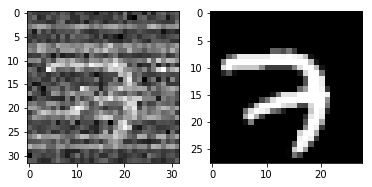

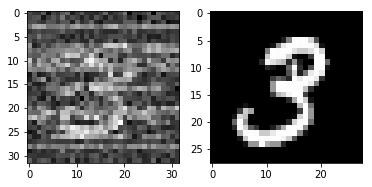

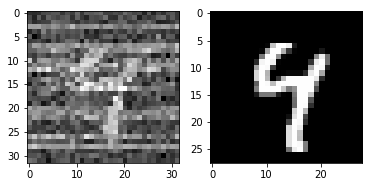

In [30]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, theta=1)

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')

Step: 90, Loss: 13.2474

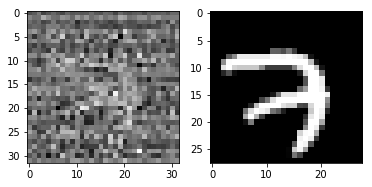

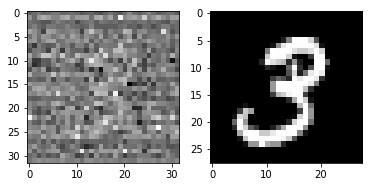

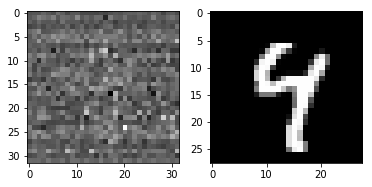

In [18]:
inputs = tf.constant(infovae.InfoVAE.preprocess(mnist.train.images[0:3, ...]))
recon = reconstruct(inputs, 100, beta=100)

for i in range(3):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon[i, :, :, 0], interpolation='nearest', cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mnist.train.images[i].reshape((28,28)), interpolation='nearest', cmap='gray')